In [2]:
from pathlib import Path
import obspy
import pandas as pd
import torch
from tqdm import tqdm
from mccc import MCCCPicker

In [3]:
input_path = Path("output/waveforms_by_station")
output_path = Path("output/mccc_results")
if not output_path.exists():
    output_path.mkdir(parents=True)

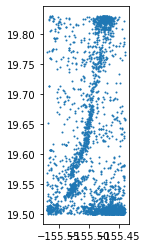

In [4]:
events = pd.read_csv("output/selected_events.csv")
plt.figure()
plt.scatter(events["longitude"], events["latitude"], s=1)
plt.axis("scaled")
plt.show()

1903


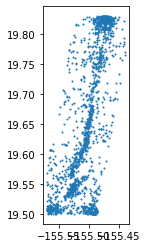

In [5]:
events = pd.read_csv("output/filt_events.csv")
print(len(events))
plt.figure()
plt.scatter(events["longitude"], events["latitude"], s=1)
plt.axis("scaled")
plt.show()

In [6]:
events = events.sort_values(by="latitude").reset_index(drop=True)
events_loa = events[events["latitude"] < 19.52]
events_kea = events[events["latitude"] > 19.8]
events_chain = events[(events["latitude"] >= 19.52) & (events["latitude"] <= 19.8)]

index_loa = events_loa.index
index_kea = events_kea.index
index_chain = events_chain.index

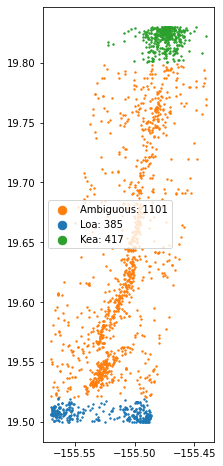

In [7]:
plt.figure(figsize=(4, 8))
plt.scatter(events_chain["longitude"], events_chain["latitude"], c="C1", s=2, label=f"Ambiguous: {len(events_chain)}")
plt.scatter(events_loa["longitude"], events_loa["latitude"], c="C0", s=2, label=f"Loa: {len(events_loa)}")
plt.scatter(events_kea["longitude"], events_kea["latitude"], c="C2", s=2, label=f"Kea: {len(events_kea)}")
plt.axis("scaled")
# plt.grid("on")
plt.legend(markerscale=6)
plt.savefig("events.png", dpi=300, bbox_inches="tight")
plt.show()

In [82]:
files = list(input_path.glob("*.npy"))
files = [Path("output/waveforms_by_station/HV.HSSD..HH.npy")]
for f in tqdm(files):

    waveforms = np.load(f, allow_pickle=True)
    if len(waveforms) == 0:
        continue
    min_nt = min([len(w) for w in waveforms])
    data = []
    for w in waveforms:
        data.append(w[:min_nt])
    data = np.array(data)
    data = torch.tensor(data, dtype=torch.float32)

    
    picker = MCCCPicker(data.cuda(), 0.01, mccc_mincc=0.5, mccc_maxlag=1.0, mccc_maxwin=100, max_niter=1, chunk_size=1000, ma=1, damp=10, whitening_waterlevel=0.1, mode="align")
    result = picker.solve()

    cc_dt = result["cc_dt"].cpu().detach().numpy()
    plt.figure()
    plt.plot(cc_dt)
    plt.savefig(output_path / f"{f.stem}_dt.png", dpi=300, bbox_inches="tight")
    plt.close()
    # plt.show()

    if np.max(np.abs(cc_dt)) < 1.0:
        cc_dt *= 0.0

    plt.figure(figsize=(8, 30))
    normalize = lambda x: (x - x.mean()) / x.std()
    t = np.arange(min_nt) * 0.01
    t_interp = np.linspace(-6, 31, 3701)
    y = []
    for i in range(len(data)):
        y_interp = np.interp(t_interp, t-cc_dt[i], normalize(data[i]), left=np.nan, right=np.nan)
        y.append(y_interp)
        plt.plot(t_interp, y_interp/6 + i, linewidth=0.5, color="k")
    plt.grid("on")
    plt.ylim([-1, len(data)+1])
    plt.xlabel("Time (s)")
    plt.ylabel("Event #")
    plt.savefig(output_path / f"{f.stem}_waveform.png", dpi=300, bbox_inches="tight")
    plt.close()
    # plt.show()

    y = np.array(y)
    plt.figure(figsize=(10, 20))
    plt.pcolormesh(t_interp, np.arange(y.shape[0]),  y, cmap="seismic", vmin=-1.5, vmax=1.5)
    plt.grid("on")
    plt.xlabel("Time (s)")
    plt.ylabel("Event #")
    plt.savefig(output_path / f"{f.stem}_colormesh.png", dpi=300, bbox_inches="tight")
    plt.close()
    # plt.show()

    # break

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
normalize = lambda x: (x - x.mean()) / x.std()

f = "output/waveforms_by_station/HV.HSSD..HH.npy"
waveforms = np.load(f, allow_pickle=True)
min_nt = min([len(w) for w in waveforms])
data = []
for w in waveforms:
    data.append(w[:min_nt])
data = np.array(data)
data = torch.tensor(data, dtype=torch.float32)
picker = MCCCPicker(data.cuda(), 0.01, mccc_mincc=0.5, mccc_maxlag=1.0, mccc_maxwin=100, max_niter=1, chunk_size=1000, ma=1, damp=10, whitening_waterlevel=0.1, mode="align")
result = picker.solve()
cc_dt = result["cc_dt"].cpu().detach().numpy()
cc_dt -= cc_dt.min()

t = np.arange(min_nt) * 0.01
t_interp = np.linspace(-8, 28, 3601)
y = []
for i in range(len(data)):
    y_interp = np.interp(t_interp, t-cc_dt[i], normalize(data[i]), left=np.nan, right=np.nan)
    y.append(y_interp)
y = np.array(y)

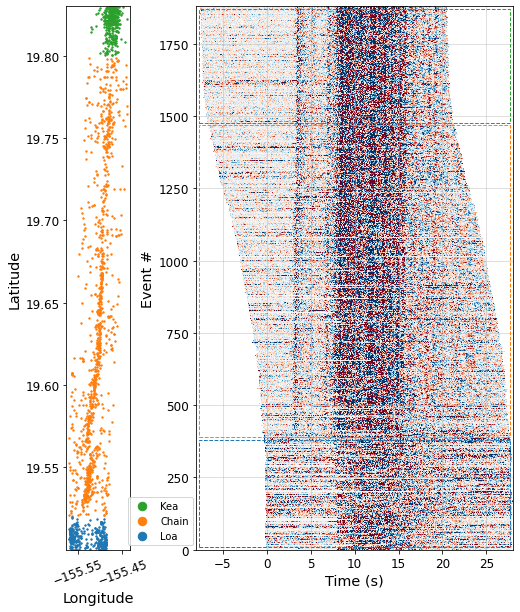

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(8, 10), gridspec_kw={"width_ratios": [1, 5]})
axes[0].scatter(events_kea["longitude"], events_kea["latitude"], c="C2", s=2, label=f"Kea")
axes[0].scatter(events_chain["longitude"], events_chain["latitude"], c="C1", s=2, label=f"Chain")
axes[0].scatter(events_loa["longitude"], events_loa["latitude"], c="C0", s=2, label=f"Loa")
axes[0].xaxis.set_tick_params(labelsize="large", rotation=20)
axes[0].yaxis.set_tick_params(labelsize="large")
axes[0].set_xticks([-155.55, -155.45])
axes[0].set_xlabel("Longitude", fontsize="x-large")
axes[0].set_ylabel("Latitude", fontsize="x-large")
axes[0].legend(markerscale=6, loc="lower left", bbox_to_anchor=(0.9, 0))
axes[0].autoscale(enable=True, axis="y", tight=True)


axes[1].pcolormesh(t_interp, np.arange(y.shape[0]),  y, cmap="RdBu", vmin=-1.5, vmax=1.5)
axes[1].grid("on", alpha=0.5)
axes[1].add_patch(plt.Rectangle((.01, 0.005), 0.98, len(events_loa)/len(events)-0.005, ls="--", ec="C0", fc="none", transform=axes[1].transAxes))
axes[1].add_patch(plt.Rectangle((.01, len(events_loa)/len(events)+0.005), 0.98, len(events_chain)/len(events)-0.005, ls="--", ec="C1", fc="none", transform=axes[1].transAxes))
axes[1].add_patch(plt.Rectangle((.01, (len(events_loa)+len(events_chain))/len(events)+0.005), 0.98, len(events_kea)/len(events)-0.01, ls="--", ec="C2", fc="none", transform=axes[1].transAxes))
axes[1].xaxis.set_tick_params(labelsize="large")
axes[1].yaxis.set_tick_params(labelsize="large")
axes[1].set_xlabel("Time (s)", fontsize="x-large")
axes[1].set_ylabel("Event #", fontsize="x-large")
axes[1].autoscale(enable=True, axis="both", tight=True)
# axes[1].set_xlim([, 30])
# fig.tight_layout()
plt.subplots_adjust(wspace = 0.35)
fig.savefig("HV.HSSD..HH.png", dpi=300, bbox_inches="tight")
# axes[1].savefig(output_path / f"{f.stem}_colormesh.png", dpi=300, bbox_inches="tight")
# axes[1].close()
# plt.show()